In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LinearRegression
from tensorflow.keras.layers import SimpleRNN, Dense

In [2]:
df = pd.read_csv(r"C:\Users\ASUS\AppData\Roaming\Bulldog\getTraf_data\4 month vol.csv")
df

,date,hour,6908,6909,6910,Total Vol
0,1/1/2022,0,259,288,83,630
1,1/1/2022,1,223,296,77,596
2,1/1/2022,2,135,243,84,462
3,1/1/2022,3,103,175,46,324
4,1/1/2022,4,96,95,7,198
...,...,...,...,...,...,...
2899,1/5/2022,19,722,959,536,2217
2900,1/5/2022,20,583,791,376,1750
2901,1/5/2022,21,503,575,240,1318
2902,1/5/2022,22,394,447,143,984


In [3]:
X = df[['6908','6909', '6910']]
y = df['Total Vol']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Standardization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

# Standardization targets 
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

In [6]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [10]:
# Create RNN model
model = Sequential()
model.add(SimpleRNN(units=100, activation='tanh', return_sequences=True, input_shape=(1, X_train_reshaped.shape[2])))
model.add(SimpleRNN(units=50, activation='tanh'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [12]:
# Train LSTM model on the training data
history = model.fit(
    X_train_reshaped, y_train, 
    epochs=60, 
    batch_size=64, 
    verbose=2, 
    validation_split=0.2,  
    callbacks=[early_stop]
)

Epoch 1/60
30/30 - 5s - loss: 0.0870 - val_loss: 0.0086 - 5s/epoch - 171ms/step
Epoch 2/60
30/30 - 0s - loss: 0.0068 - val_loss: 0.0040 - 327ms/epoch - 11ms/step
Epoch 3/60
30/30 - 0s - loss: 0.0036 - val_loss: 0.0024 - 178ms/epoch - 6ms/step
Epoch 4/60
30/30 - 0s - loss: 0.0026 - val_loss: 0.0016 - 237ms/epoch - 8ms/step
Epoch 5/60
30/30 - 0s - loss: 0.0019 - val_loss: 0.0012 - 149ms/epoch - 5ms/step
Epoch 6/60
30/30 - 0s - loss: 0.0015 - val_loss: 9.3820e-04 - 175ms/epoch - 6ms/step
Epoch 7/60
30/30 - 0s - loss: 0.0011 - val_loss: 7.0871e-04 - 298ms/epoch - 10ms/step
Epoch 8/60
30/30 - 0s - loss: 9.0716e-04 - val_loss: 5.6296e-04 - 210ms/epoch - 7ms/step
Epoch 9/60
30/30 - 0s - loss: 7.2814e-04 - val_loss: 7.1188e-04 - 395ms/epoch - 13ms/step
Epoch 10/60
30/30 - 0s - loss: 7.3520e-04 - val_loss: 5.0040e-04 - 278ms/epoch - 9ms/step
Epoch 11/60
30/30 - 0s - loss: 5.6026e-04 - val_loss: 3.5840e-04 - 156ms/epoch - 5ms/step
Epoch 12/60
30/30 - 0s - loss: 4.7070e-04 - val_loss: 2.9867e-04 

In [13]:
# y predictions
y_train_pred = model.predict(X_train_reshaped)
y_test_pred = model.predict(X_test_reshaped)


19/19 [==============================] - 0s 3ms/step


In [14]:
# Calculate MSE for training and test sets

mse_test = np.mean((y_test - y_test_pred.flatten())**2)
mse_train = np.mean((y_train - y_train_pred.flatten())**2)
print(f'Mean Squared Error train: {mse_test}')
print(f'Mean Squared Error test: {mse_train}')

Mean Squared Error train: 2.115613946365326
Mean Squared Error test: 2.0507741596934985


In [15]:
# MAPE function
def mean_absolute_percentage_error(y_original, y_pred): 
    y_original, y_pred = np.array(y_original), np.array(y_pred)
    return np.mean(np.abs((y_original - y_pred) / y_original)) * 100


In [16]:
# Calculate MAPE for training and test sets
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

print(f'Training MAPE: {mape_train}%')
print(f'Test MAPE: {mape_test}%')

Training MAPE: 5.508993370855774%
Test MAPE: 4.227828255798661%


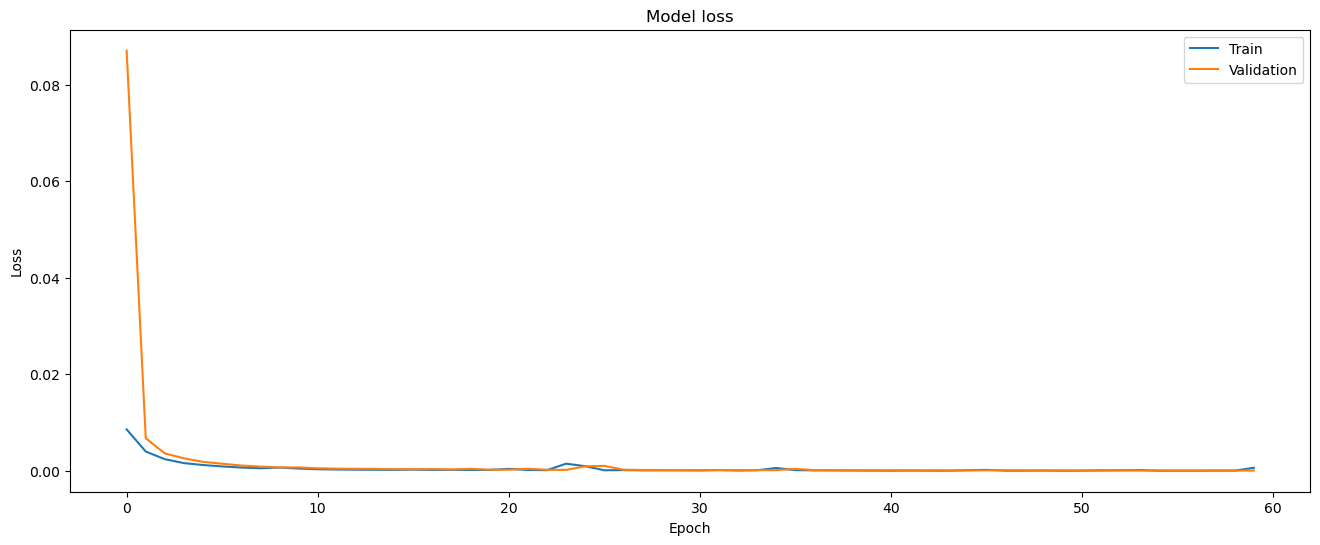

In [20]:
plt.figure(figsize=(16, 6))
plt.plot(history.history['val_loss'])


plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [22]:
#INVERSING/ PUTTING BACK  the scale
actual_test = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
predicted_test = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()


In [23]:
#print the results
results_df = pd.DataFrame(data={'Actual': actual_test, 'Predicted': predicted_test})
print(results_df)

     Actual    Predicted
0    1107.0  1098.911987
1     166.0   130.454926
2    1353.0  1351.856445
3    3002.0  3041.303223
4     526.0   497.048798
..      ...          ...
576   177.0   141.888153
577   347.0   313.535614
578   979.0   965.660950
579  2894.0  2927.323242
580  2339.0  2354.614014

[581 rows x 2 columns]


In [24]:
results_df.index = pd.to_datetime(results_df.index)


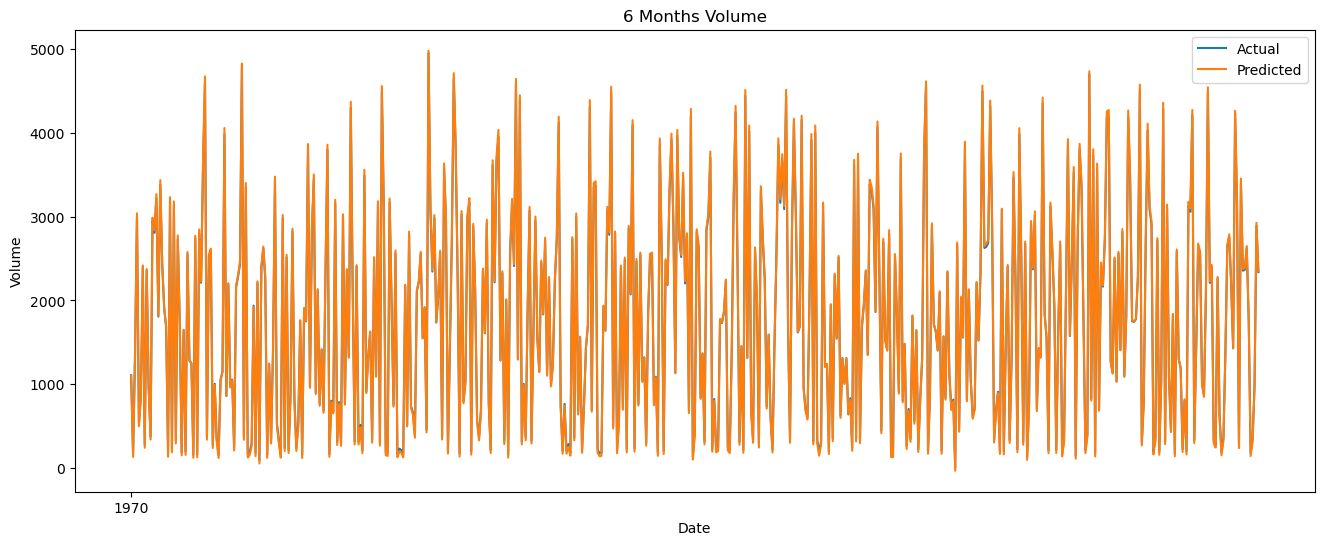

In [25]:
plt.figure(figsize=(16, 6))
plt.plot(results_df['Actual'], label='Actual')
plt.plot(results_df['Predicted'], label='Predicted')


plt.title('6 Months Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()